LangGraph 스트리밍

StateGraph의 stream 메서드

stream 메서드는 단일 입력에 대한 그래프 단계를 스트리밍하는 기능을 제공합니다.

**매개변수**

input (Union[dict[str, Any], Any]): 그래프에 대한 입력

config (Optional[RunnableConfig]): 실행 구성

stream_mode (Optional[Union[StreamMode, list[StreamMode]]]): 출력 스트리밍 모드

output_keys (Optional[Union[str, Sequence[str]]]): 스트리밍할 키

interrupt_before (Optional[Union[All, Sequence[str]]]): 실행 전에 중단할 노드

interrupt_after (Optional[Union[All, Sequence[str]]]): 실행 후에 중단할 노드

debug (Optional[bool]): 디버그 정보 출력 여부

subgraphs (bool): 하위 그래프 스트리밍 여부


**반환값**


Iterator[Union[dict[str, Any], Any]]: 그래프의 각 단계 출력.
출력 형태는 stream_mode에 따라 다름


**주요 기능**


1. 입력된 설정에 따라 그래프 실행을 스트리밍 방식으로 처리

2. 다양한 스트리밍 모드 지원 (values, updates, debug)

3. 콜백 관리 및 오류 처리

4. 재귀 제한 및 중단 조건 처리


**스트리밍 모드**

values: 각 단계의 현재 상태 값 출력

updates: 각 단계의 상태 업데이트만 출력

debug: 각 단계의 디버그 이벤트 출력

In [ ]:
!pip -q install langchain langchain-openai langchain-community duckduckgo-search gradio langgraph langchain-teddynote


In [ ]:
from typing import Annotated, List, Dict
from typing_extensions import TypedDict

from langchain_core.tools import tool
from langchain_openai import ChatOpenAI
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition
from langchain_teddynote.graphs import visualize_graph
from langchain_teddynote.tools import GoogleNews


import os

# OpenAI API 키 설정 (사용자가 입력해야 함)
# from google.colab import userdata

# api_key=userdata.get('api_key')
# api_key2=userdata.get('api_key2')
# api_key3=userdata.get('api_key3')
# os.environ["OPENAI_API_KEY"] = api_key
# os.environ["LANGCHAIN_API_KEY"] = api_key2
# os.environ["TAVILY_API_KEY"] = api_key3

from dotenv import load_dotenv

load_dotenv()
# OpenAI API 클라이언트 생성
OPENAPI_KEY = os.getenv("OPENAI_API_KEY")
LangSmith_KEY = os.getenv("LANGCHAIN_API_KEY")
TAVILY_API_KEY = os.getenv("TAVILY_API_KEY")

# 2) LangSmith 연동 필수 환경변수
os.environ["LANGCHAIN_TRACING_V2"] = "true"      # 트레이싱 활성화
os.environ["LANGSMITH_ENDPOINT"]   = "https://api.smith.langchain.com"  # 기본값
os.environ["LANGSMITH_PROJECT"]    = "langgraph_4"

from langchain_teddynote.tools.tavily import TavilySearch
import os


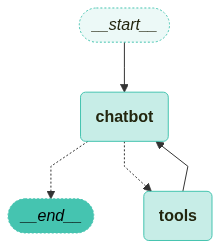

In [3]:

########## 1. 상태 정의 ##########
# 상태 정의
class State(TypedDict):
    # 메시지 목록 주석 추가
    messages: Annotated[list, add_messages]
    dummy_data: Annotated[str, "dummy"]


########## 2. 도구 정의 및 바인딩 ##########
# 도구 초기화
# 키워드로 뉴스 검색하는 도구 생성
news_tool = GoogleNews()


@tool
def search_keyword(query: str) -> List[Dict[str, str]]:
    """Look up news by keyword"""
    news_tool = GoogleNews()
    return news_tool.search_by_keyword(query, k=5)


tools = [search_keyword]

# LLM 초기화
llm = ChatOpenAI(model="gpt-4o-mini")

# 도구와 LLM 결합
llm_with_tools = llm.bind_tools(tools)


########## 3. 노드 추가 ##########
# 챗봇 함수 정의
def chatbot(state: State):
    # 메시지 호출 및 반환
    return {
        "messages": [llm_with_tools.invoke(state["messages"])],
        "dummy_data": "[chatbot] 호출, dummy data",  # 테스트를 위하여 더미 데이터를 추가합니다.
    }


# 상태 그래프 생성
graph_builder = StateGraph(State)

# 챗봇 노드 추가
graph_builder.add_node("chatbot", chatbot)


# 도구 노드 생성 및 추가
tool_node = ToolNode(tools=tools)

# 도구 노드 추가
graph_builder.add_node("tools", tool_node)

# 조건부 엣지
graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)

########## 4. 엣지 추가 ##########

# tools > chatbot
graph_builder.add_edge("tools", "chatbot")

# START > chatbot
graph_builder.add_edge(START, "chatbot")

# chatbot > END
graph_builder.add_edge("chatbot", END)

########## 5. 그래프 컴파일 ##########

# 그래프 빌더 컴파일
graph = graph_builder.compile()

########## 6. 그래프 시각화 ##########
# 그래프 시각화
visualize_graph(graph)

In [4]:
from langchain_core.runnables import RunnableConfig

# 질문
question = "2024년 노벨 문학상 관련 뉴스를 알려주세요."

# 초기 입력 상태를 정의
input = State(dummy_data="테스트 문자열", messages=[("user", question)])

# config 설정
config = RunnableConfig(
    recursion_limit=10,  # 최대 10개의 노드까지 방문. 그 이상은 RecursionError 발생
    configurable={"thread_id": "1"},  # 스레드 ID 설정
    tags=["my-tag"],  # Tag
)


In [5]:
for event in graph.stream(input=input, config=config):
    for key, value in event.items():
        print(f"\n[ {key} ]\n")
        # value 에 messages 가 존재하는 경우
        if "messages" in value:
            messages = value["messages"]
            # 가장 최근 메시지 1개만 출력합니다.
            value["messages"][-1].pretty_print()



[ chatbot ]

================================== Ai Message ==================================
Tool Calls:
  search_keyword (call_GdOKaWNLDH92Od9oXblzh0JC)
 Call ID: call_GdOKaWNLDH92Od9oXblzh0JC
  Args:
    query: 2024 노벨 문학상

[ tools ]

================================= Tool Message =================================
Name: search_keyword

[{"url": "https://news.google.com/rss/articles/CBMiTkFVX3lxTE1WR2QxeXktVFlQVWE2NUgwVjM4SWJfX0JZVk1Tdm5abWxfQk5NV1FxVmQybnIycF91SmdzNHlaQTBsWEczQ1FuUWFIZUJJdw?oc=5", "content": "[1만호 100대 사건]〈96〉한강, 한국인 최초 노벨문학상 수상 - 전자신문"}, {"url": "https://news.google.com/rss/articles/CBMiW0FVX3lxTE5CbDJEWU1nZUxVTkZmS3lHTTRycEVPZ2lpRUFPYVlwVVYwbGNKaTdnbWpkS25wY2tZU1pEa0JkZFltQnNRX05teHp5WWd4VXpWbFl3TTNNQVpqZzjSAWBBVV95cUxPTU01d0ZUbWtnX1p6S2FZOFJiZGQwcGYzZWRvZFFIOTlxOUR2SGdaejFqdEI3enVCLXRDc2o5YTVnUUdic1lrNVg5SS1adlBhUUx0MHRZaXVlMk43cGF5WXI?oc=5", "content": "한강, 한국 첫 노벨문학상…\"어두운 밤에도 우릴 잇는 건 언어\"(종합2보) - 연합뉴스"}, {"url": "https://news.google.com/rss/articles/CBMioAFBV

In [6]:
# channels 에 정의된 키 목록을 출력합니다.
print(list(graph.channels.keys()))


['messages', 'dummy_data', '__start__', '__pregel_tasks', 'branch:to:chatbot', 'branch:to:tools']


In [7]:
# 질문
question = "2024년 노벨 문학상 관련 뉴스를 알려주세요."

# 초기 입력 State 를 정의
input = State(dummy_data="테스트 문자열", messages=[("user", question)])

# config 설정
config = RunnableConfig(
    recursion_limit=10,  # 최대 10개의 노드까지 방문. 그 이상은 RecursionError 발생
    configurable={"thread_id": "1"},  # 스레드 ID 설정
    tags=["my-rag"],  # Tag
)

for event in graph.stream(
    input=input,
    config=config,
    output_keys=["dummy_data"],  # messages 를 추가해 보세요!
):
    for key, value in event.items():
        # key 는 노드 이름
        print(f"\n[ {key} ]\n")

        # dummy_data 가 존재하는 경우
        if value:
            # value 는 노드의 출력값
            print(value.keys())
            # dummy_data key 가 존재하는 경우
            if "dummy_data" in value:
                print(value["dummy_data"])



[ chatbot ]

dict_keys(['dummy_data'])
[chatbot] 호출, dummy data

[ tools ]


[ chatbot ]

dict_keys(['dummy_data'])
[chatbot] 호출, dummy data


In [8]:
# 질문
question = "2024년 노벨 문학상 관련 뉴스를 알려주세요."

# 초기 입력 State 를 정의
input = State(dummy_data="테스트 문자열", messages=[("user", question)])

# config 설정
config = RunnableConfig(
    recursion_limit=10,  # 최대 10개의 노드까지 방문. 그 이상은 RecursionError 발생
    configurable={"thread_id": "1"},  # 스레드 ID 설정
    tags=["my-rag"],  # Tag
)

for event in graph.stream(
    input=input,
    config=config,
    output_keys=["messages"],  # messages 만 출력
):
    for key, value in event.items():
        # messages 가 존재하는 경우
        if value and "messages" in value:
            # key 는 노드 이름
            print(f"\n[ {key} ]\n")
            # messages 의 마지막 요소의 content 를 출력합니다.
            print(value["messages"][-1].content)



[ chatbot ]



[ tools ]

[{"url": "https://news.google.com/rss/articles/CBMiTkFVX3lxTE1WR2QxeXktVFlQVWE2NUgwVjM4SWJfX0JZVk1Tdm5abWxfQk5NV1FxVmQybnIycF91SmdzNHlaQTBsWEczQ1FuUWFIZUJJdw?oc=5", "content": "[1만호 100대 사건]〈96〉한강, 한국인 최초 노벨문학상 수상 - 전자신문"}, {"url": "https://news.google.com/rss/articles/CBMioAFBVV95cUxNSC1MaVZoMmVGZWktR1NaMDV0OFhLUUxZTXY5TEJyWGdvRnp4WG5JYk9OZkxuMGJXZDQ1cnlwZXBiV0hXX3AtUUhRN1IzeVdZZi1BYjhGbFI1Zk1pOXUzX1llRzRGZmJHbXRKM0RBM2RfSnBoVTA0aTlKSlpPVGJ4N0R5cmg5VDNyOEdMRjFfUkhwUVBLOFBqVGtyeHREZTRw?oc=5", "content": "아시아 여성 최초 노벨문학상 수상🏅 전세계가 주목한 작가 한강은 누구? - www .oiv .int."}, {"url": "https://news.google.com/rss/articles/CBMibEFVX3lxTE9saEhrVVp3RWFCR1B4SWlDVGhtQ2ItcWRXTFdkd05TOXVUMnNqbjBHRVZHV3NKTng0U3A4Zl8yMVFNenZpZ0N5UUtSX2p2RDBvY2k3TjJpQTZDemo1cUhrTjBzUlJYMlVMbWZZQQ?oc=5", "content": "한강, “언어는 우리를 잇는 실”...‘노벨문학상 수상 강연’ 전문 - 재외동포신문"}, {"url": "https://news.google.com/rss/articles/CBMickFVX3lxTE1uTEo1X21rV25oM0V3c2xpSmpWdTRoQmZ4cWV5WWVKSldPYmZOSFhPcVd0ZUgwdkxoeUdpX2VQQVp

In [9]:
# 질문
question = "2024년 노벨 문학상 관련 뉴스를 알려주세요."

# 초기 입력 State 를 정의
input = State(dummy_data="테스트 문자열", messages=[("user", question)])

# config 설정
config = RunnableConfig(
    recursion_limit=10,  # 최대 10개의 노드까지 방문. 그 이상은 RecursionError 발생
    configurable={"thread_id": "1"},  # 스레드 ID 설정
    tags=["my-rag"],  # Tag
)

# values 모드로 스트리밍 출력
for event in graph.stream(
    input=input,
    stream_mode="values",  # 기본값
):
    for key, value in event.items():
        # key 는 state 의 key 값
        print(f"\n[ {key} ]\n")
        if key == "messages":
            print(f"메시지 개수: {len(value)}")
            # print(value)
    print("===" * 10, " 단계 ", "===" * 10)



[ messages ]

메시지 개수: 1

[ dummy_data ]

==============================  단계  ==============================

[ messages ]

메시지 개수: 2

[ dummy_data ]

==============================  단계  ==============================

[ messages ]

메시지 개수: 3

[ dummy_data ]

==============================  단계  ==============================

[ messages ]

메시지 개수: 4

[ dummy_data ]

==============================  단계  ==============================


In [10]:
# 질문
question = "2024년 노벨 문학상 관련 뉴스를 알려주세요."

# 초기 입력 State 를 정의
input = State(dummy_data="테스트 문자열", messages=[("user", question)])

# config 설정
config = RunnableConfig(
    recursion_limit=10,  # 최대 10개의 노드까지 방문. 그 이상은 RecursionError 발생
    configurable={"thread_id": "1"},  # 스레드 ID 설정
    tags=["my-rag"],  # Tag
)

# updates 모드로 스트리밍 출력
for event in graph.stream(
    input=input,
    stream_mode="updates",  # 기본값
):
    for key, value in event.items():
        # key 는 노드 이름
        print(f"\n[ {key} ]\n")

        # value 는 노드의 출력값
        print(value.keys())

        # value 에는 state 가 dict 형태로 저장(values 의 key 값)
        if "messages" in value:
            print(f"메시지 개수: {len(value['messages'])}")
            # print(value["messages"])
    print("===" * 10, " 단계 ", "===" * 10)



[ chatbot ]

dict_keys(['messages', 'dummy_data'])
메시지 개수: 1
==============================  단계  ==============================

[ tools ]

dict_keys(['messages'])
메시지 개수: 1
==============================  단계  ==============================

[ chatbot ]

dict_keys(['messages', 'dummy_data'])
메시지 개수: 1
==============================  단계  ==============================


In [11]:
# 질문
question = "2024년 노벨 문학상 관련 뉴스를 알려주세요."

# 초기 입력 State 를 정의
input = State(dummy_data="테스트 문자열", messages=[("user", question)])

# config 설정
config = RunnableConfig(
    recursion_limit=10,  # 최대 10개의 노드까지 방문. 그 이상은 RecursionError 발생
    configurable={"thread_id": "1"},  # 스레드 ID 설정
    tags=["my-rag"],  # Tag
)

for event in graph.stream(
    input=input,
    config=config,
    stream_mode="updates",  # 기본값
    interrupt_before=["tools"],  # tools 노드 이전에 스트리밍 중단
):
    for key, value in event.items():
        # key 는 노드 이름
        print(f"\n[{key}]\n")

        # value 는 노드의 출력값
        if isinstance(value, dict):
            print(value.keys())
            if "messages" in value:
                print(value["messages"])

        # value 에는 state 가 dict 형태로 저장(values 의 key 값)
        if "messages" in value:
            print(f"메시지 개수: {len(value['messages'])}")
    print("===" * 10, " 단계 ", "===" * 10)



[chatbot]

dict_keys(['messages', 'dummy_data'])
[AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_7rmdNynsFuCIpqDvNy6rcW1s', 'function': {'arguments': '{"query":"2024년 노벨 문학상"}', 'name': 'search_keyword'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 21, 'prompt_tokens': 57, 'total_tokens': 78, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_560af6e559', 'id': 'chatcmpl-CBy0FPmlp4KmljCh6D2B4xVT1qXPc', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--02713e1f-3f08-46f1-8e7c-8b906b3163e4-0', tool_calls=[{'name': 'search_keyword', 'args': {'query': '2024년 노벨 문학상'}, 'id': 'call_7rmdNynsFuCIpqDvNy6rcW1s', 'type': 'tool_call'}], usage_metadata={'input_tokens': 57,

In [12]:
# 질문
question = "2024년 노벨 문학상 관련 뉴스를 알려주세요."

# 초기 입력 State 를 정의
input = State(dummy_data="테스트 문자열", messages=[("user", question)])

# config 설정
config = RunnableConfig(
    recursion_limit=10,  # 최대 10개의 노드까지 방문. 그 이상은 RecursionError 발생
    configurable={"thread_id": "1"},  # 스레드 ID 설정
    tags=["my-rag"],  # Tag
)

for event in graph.stream(
    input=input,
    config=config,
    stream_mode="updates",
    interrupt_after=["tools"],  # tools 실행 후 interrupt
):
    for value in event.values():
        # key 는 노드 이름
        print(f"\n[{key}]\n")

        if isinstance(value, dict):
            # value 는 노드의 출력값
            print(value.keys())
            if "messages" in value:
                print(value["messages"])

        # value 에는 state 가 dict 형태로 저장(values 의 key 값)
        if "messages" in value:
            print(f"메시지 개수: {len(value['messages'])}")



[__interrupt__]

dict_keys(['messages', 'dummy_data'])
[AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_PALZ54N2SUEBgu3ScRmkTVZg', 'function': {'arguments': '{"query":"2024년 노벨 문학상"}', 'name': 'search_keyword'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 21, 'prompt_tokens': 57, 'total_tokens': 78, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_560af6e559', 'id': 'chatcmpl-CBy0GDvytvAp0063wW3M5YHN3jZwB', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--db63cfb1-c94c-4f84-bfe9-938672fee27e-0', tool_calls=[{'name': 'search_keyword', 'args': {'query': '2024년 노벨 문학상'}, 'id': 'call_PALZ54N2SUEBgu3ScRmkTVZg', 'type': 'tool_call'}], usage_metadata={'input_tokens